<a href="https://colab.research.google.com/github/sowmi1407/Deep_recall1/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Classification with PyTorch

## 1. Getting the data and getting it ready

In [ ]:
from sklearn.datasets import make_circles

#making 1000 samples
n_samples=1000

#creating circles
X,Y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)


In [ ]:
len(X),len(Y)

(1000, 1000)

In [ ]:
#creating a pandas dataframes

import pandas as pd
circles=pd.DataFrame({'X1': X[:,0],
                     'X2': X[:,1],
                     'label':Y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


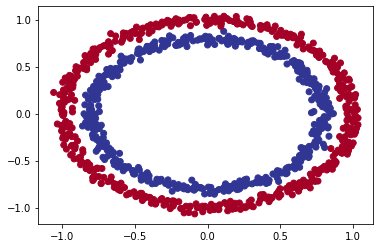

In [ ]:
#visualising the dataset
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu)


In [ ]:
 X.shape,Y.shape

((1000, 2), (1000,))

In [ ]:
#getting the data into tensors
import torch
X=torch.from_numpy(X).type(torch.float)
Y=torch.from_numpy(Y).type(torch.float)


In [ ]:
#splitting the datasets
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)


In [ ]:
len(X_train),len(X_test)

(800, 200)

In [ ]:
X_train.shape,X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

## 2. Building a Model

1. Setup device agnostic code
2. Construct a model
3. Define a loss function and optimizer
4. Create a training and testing loop

In [ ]:
import torch
from torch import nn
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#constructing a small model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #creating the layers
    self.layer_1=nn.Linear(in_features=2,out_features=6) #takes in 2 features and upscales it to 6
    self.layer_2=nn.Linear(in_features=6,out_features=1) #the input is the same as the output

  #defining the forward
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) #x->layer_1->layer_2


In [ ]:
#instantiating the model
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
#using nn.Sequential()

model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=6),
    nn.Linear(in_features=6,out_features=1)
).to(device)

In [ ]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.1509,  0.3945],
                      [-0.5332,  0.6015],
                      [-0.6122, -0.6113],
                      [ 0.5410,  0.6102],
                      [-0.2806,  0.2379],
                      [-0.4765,  0.5332]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2150,  0.0402, -0.2205,  0.4027,  0.3166, -0.3437], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3768, -0.2937, -0.2034, -0.2355, -0.2465,  0.0300]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.2951], device='cuda:0'))])

In [ ]:
#making predictions
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape : {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\n First ten labels : \n{Y_test[:10]}")

Length of predictions : 200, Shape: torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.7282],
        [-0.7320],
        [-0.4288],
        [-0.8142],
        [ 0.0307],
        [ 0.0248],
        [-0.3500],
        [-0.1717],
        [-0.4486],
        [-0.7271]], device='cuda:0')

 First ten labels : 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


##3. Picking a loss function and optimizer

In [ ]:
loss_fn=nn.BCEWithLogitsLoss() #inbuilt with sigmoid layer
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01,
                          momentum=0.9)

`nn.BCELoss()` loss needs the input that is the output of a sigmoid layer

In [ ]:
#creating the evaluation metric
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

##4. Training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards
5. Optimizer step

The model outputs logits. We have to convert the logits to prediction probabilities. Then the prediction probabilities have to be converted to labels

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))
y_logits[:10]

tensor([[-0.7282],
        [-0.7320],
        [-0.4288],
        [-0.8142],
        [ 0.0307],
        [ 0.0248],
        [-0.3500],
        [-0.1717],
        [-0.4486],
        [-0.7271]], device='cuda:0')

In [ ]:
#using the  sigmoid layer to convert them to prediction probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs[:10]

tensor([[0.3256],
        [0.3248],
        [0.3944],
        [0.3070],
        [0.5077],
        [0.5062],
        [0.4134],
        [0.4572],
        [0.3897],
        [0.3258]], device='cuda:0')

In [ ]:
y_pred=torch.round(y_pred_probs)
y_pred[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
#building a training and test loop
epochs=200

X_train,Y_train=X_train.to(device),Y_train.to(device)
X_test,Y_test=X_test.to(device),Y_test.to(device)

epoch_count=[]
training_loss=[]
test_loss=[]

for i in range(epochs):
  epoch_count.append(i)

  model_0.train()
  #forward pass
  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  #calculating loss and accuracy
  loss=loss_fn(y_logits,Y_train)
  training_loss.append(loss)
  acc=accuracy_fn(Y_train,y_preds)

  #optimizer zero grad
  optimizer.zero_grad()

  #back_prop
  loss.backward()

  #optimizer step
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits,Y_test)
    test_acc=accuracy_fn(Y_test,test_preds)

  if i%10==0:
    print(f"Epoch: {i} | Loss : {loss:.5f}, Acc: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss : 0.72164, Acc: 42.12% | Test_loss: 0.71625, Test Acc: 45.00%
Epoch: 10 | Loss : 0.71492, Acc: 45.62% | Test_loss: 0.70929, Test Acc: 46.00%
Epoch: 20 | Loss : 0.70612, Acc: 47.62% | Test_loss: 0.70183, Test Acc: 48.00%
Epoch: 30 | Loss : 0.70059, Acc: 48.62% | Test_loss: 0.69788, Test Acc: 48.00%
Epoch: 40 | Loss : 0.69768, Acc: 50.38% | Test_loss: 0.69631, Test Acc: 45.50%
Epoch: 50 | Loss : 0.69610, Acc: 50.88% | Test_loss: 0.69570, Test Acc: 44.50%
Epoch: 60 | Loss : 0.69512, Acc: 50.25% | Test_loss: 0.69540, Test Acc: 49.00%
Epoch: 70 | Loss : 0.69446, Acc: 49.62% | Test_loss: 0.69522, Test Acc: 52.50%
Epoch: 80 | Loss : 0.69401, Acc: 49.50% | Test_loss: 0.69510, Test Acc: 49.50%
Epoch: 90 | Loss : 0.69371, Acc: 49.75% | Test_loss: 0.69502, Test Acc: 49.50%
Epoch: 100 | Loss : 0.69349, Acc: 49.75% | Test_loss: 0.69497, Test Acc: 49.50%
Epoch: 110 | Loss : 0.69335, Acc: 50.12% | Test_loss: 0.69494, Test Acc: 49.50%
Epoch: 120 | Loss : 0.69324, Acc: 49.25% | Test_los

##5. Making predictions and evaluating the model

Making predictions and plotting them

In [ ]:
import requests
from pathlib import Path

 #downloading helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading the file")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary


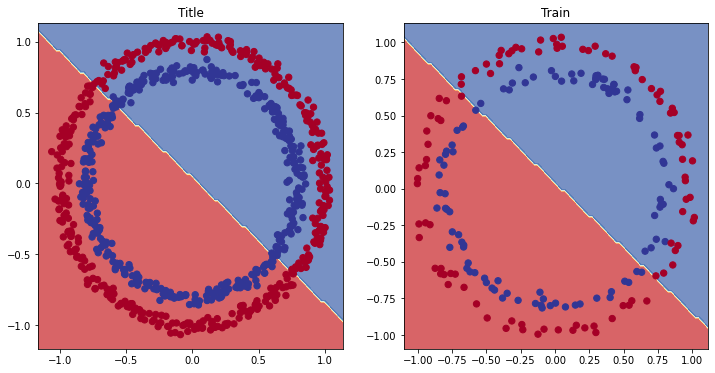

In [ ]:
#plotting decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Title')
plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title('Train')
plot_decision_boundary(model_0,X_test,Y_test)

##6. Non Linearity



###6.1 Building a model with non linearity

In [ ]:
from torch import nn

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2, out_features=10)
    self.layer_2=nn.Linear(in_features=10, out_features=10)
    self.layer_3=nn.Linear(in_features=10, out_features=1)
    self.relu=nn.ReLU()
  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [ ]:
model_2=CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
model_2.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.3408, -0.3455],
                      [-0.6520, -0.1981],
                      [-0.2548,  0.4877],
                      [ 0.5465, -0.4591],
                      [ 0.1646, -0.2935],
                      [ 0.1315, -0.2199],
                      [-0.1758,  0.3620],
                      [ 0.4684,  0.7042],
                      [ 0.4875,  0.6181],
                      [ 0.0557, -0.0329]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.6229,  0.1580,  0.5081,  0.2090,  0.4804,  0.1852,  0.3830,  0.4490,
                      -0.6010,  0.1200], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1687, -0.2268,  0.1422, -0.2297, -0.1279, -0.1488, -0.1727,  0.0042,
                        0.1853, -0.1378],
                      [ 0.2943,  0.2722,  0.0663, -0.2220,  0.0811,  0.1448,  0.2467,  0.2850,
                       -0.2802, -0.2422],
                      [ 0.2884,  0.1701, -0.1429,  0

In [ ]:
#loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                       lr=0.01,
                       momentum=0.9)

In [ ]:
#training

X_train, y_train= X_train.to(device), Y_train.to(device)
X_test, y_test= X_test.to(device), Y_test.to(device)

epochs=1000
for epoch in range(epochs):
  model_2.train()
  y_logits=model_2(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  optimizer.zero_grad()
  acc=accuracy_fn(y_train,y_preds)
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits=model_2(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_preds)

  if epoch%100==0:
    print(f"Loss : {loss} | Accuracy : {acc} | Test Loss : {test_loss} | Test Accuracy : {test_acc}")

Loss : 0.6945081949234009 | Accuracy : 49.0 | Test Loss : 0.6952461004257202 | Test Accuracy : 46.0
Loss : 0.6922889351844788 | Accuracy : 50.5 | Test Loss : 0.6938880681991577 | Test Accuracy : 47.5
Loss : 0.6904023885726929 | Accuracy : 51.74999999999999 | Test Loss : 0.6928812265396118 | Test Accuracy : 48.5
Loss : 0.6885403394699097 | Accuracy : 52.5 | Test Loss : 0.6918535232543945 | Test Accuracy : 48.5
Loss : 0.6864063739776611 | Accuracy : 53.0 | Test Loss : 0.6906248331069946 | Test Accuracy : 49.0
Loss : 0.6835331320762634 | Accuracy : 53.75 | Test Loss : 0.6888226270675659 | Test Accuracy : 50.5
Loss : 0.67966228723526 | Accuracy : 54.50000000000001 | Test Loss : 0.6859390139579773 | Test Accuracy : 53.0
Loss : 0.6741352677345276 | Accuracy : 57.25 | Test Loss : 0.6816197633743286 | Test Accuracy : 54.0
Loss : 0.6654933094978333 | Accuracy : 61.625 | Test Loss : 0.6748033761978149 | Test Accuracy : 56.49999999999999
Loss : 0.6516679525375366 | Accuracy : 74.125 | Test Loss :

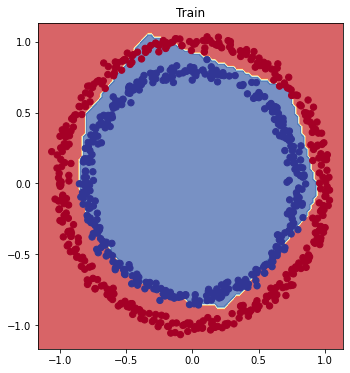

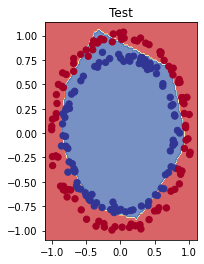

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.figure()
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)


##Multiclass Classification Problem


##Creating a dataset

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
NUM_CLASSES=5
NUM_FEATURES=2


In [ ]:
X_blob, y_blob= make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2)


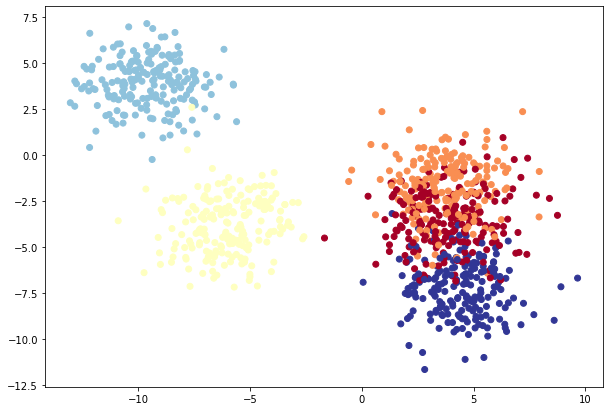

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

##Creating a multiclass classification model

In [ ]:
from torch import nn

class MultiClassModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=10)
    self.layer_4=nn.Linear(in_features=10,out_features=5)
    self.relu=nn.ReLU()
  def forward(self,x):
    Z_1=self.relu(self.layer_1(x))
    Z_2=self.relu(self.layer_2(Z_1))
    Z_3=self.relu(self.layer_3(Z_2))
    Z_4=self.relu(self.layer_4(Z_3))
    return Z_4

In [ ]:
model_mmc=MultiClassModelV0().to(device)
model_mmc

MultiClassModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=5, bias=True)
  (relu): ReLU()
)

In [ ]:
X_train, y_train= X_blob_train.to(device), y_blob_train.to(device)
X_test, y_test= X_blob_test.to(device), y_blob_test.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_mmc.parameters(),
                           lr=0.01)

In [ ]:
model_mmc.eval()
with torch.inference_mode():
  model_logits=model_mmc(X_test).to(device)
  model_logits[:10]
  model_probs=torch.softmax(model_logits, dim=1)

print(model_probs[:10])
torch.argmax(model_probs[10])

tensor([[0.1893, 0.2009, 0.1893, 0.1893, 0.2313],
        [0.2249, 0.2202, 0.1764, 0.1764, 0.2020],
        [0.1849, 0.2169, 0.1849, 0.1849, 0.2283],
        [0.1820, 0.2196, 0.1820, 0.1820, 0.2346],
        [0.1872, 0.2118, 0.1872, 0.1872, 0.2267],
        [0.1856, 0.2160, 0.1856, 0.1856, 0.2273],
        [0.1782, 0.2208, 0.1782, 0.1782, 0.2448],
        [0.1866, 0.2145, 0.1866, 0.1866, 0.2258],
        [0.1694, 0.2404, 0.1694, 0.1694, 0.2515],
        [0.1831, 0.2175, 0.1831, 0.1831, 0.2332]], device='cuda:0')


tensor(4, device='cuda:0')

In [ ]:
#converting model's predictions probabilities to prediction labels
model_preds=torch.argmax(model_probs, dim=1)
model_preds

tensor([4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 1, 1, 1, 4, 4, 0, 1,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4,
        4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 1, 4,
        4, 0, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4,
        0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4,
        4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 4, 0, 4, 0, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')

In [ ]:
epochs=2000

for epoch in range(epochs):
  model_mmc.train()
  y_logits=model_mmc(X_train)
  y_preds=torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_mmc.eval()
  with torch.inference_mode():
    test_logits=model_mmc(X_test)
    test_preds=torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_test)
    tess_acc=accuracy_fn(y_test,test_preds)

  if epoch%100==0:
    print(f" Loss : {loss} | Accuracy : {acc} | Test_loss : {test_loss} | Test_Accuracy : {test_acc}")


 Loss : 1.615801215171814 | Accuracy : 19.25 | Test_loss : 1.5766714811325073 | Test_Accuracy : 84.5
 Loss : 0.5902823805809021 | Accuracy : 80.75 | Test_loss : 0.6028038859367371 | Test_Accuracy : 84.5
 Loss : 0.5834871530532837 | Accuracy : 80.625 | Test_loss : 0.6080310344696045 | Test_Accuracy : 84.5
 Loss : 0.5764225125312805 | Accuracy : 81.625 | Test_loss : 0.6158984303474426 | Test_Accuracy : 84.5
 Loss : 0.5738463997840881 | Accuracy : 81.625 | Test_loss : 0.6281755566596985 | Test_Accuracy : 84.5
 Loss : 0.5715603232383728 | Accuracy : 81.5 | Test_loss : 0.6356394290924072 | Test_Accuracy : 84.5
 Loss : 0.5690560340881348 | Accuracy : 81.375 | Test_loss : 0.6408113837242126 | Test_Accuracy : 84.5
 Loss : 0.5685956478118896 | Accuracy : 80.625 | Test_loss : 0.6419637203216553 | Test_Accuracy : 84.5
 Loss : 0.5726173520088196 | Accuracy : 80.875 | Test_loss : 0.6392229795455933 | Test_Accuracy : 84.5
 Loss : 0.5698445439338684 | Accuracy : 80.625 | Test_loss : 0.645948469638824

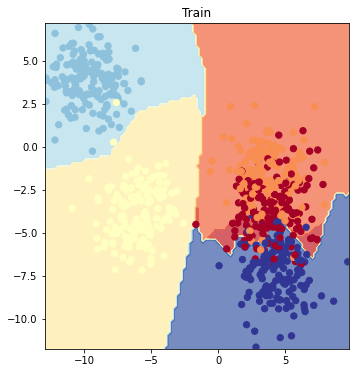

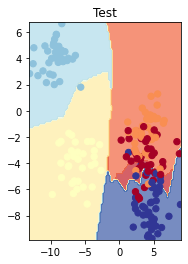

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_mmc,X_train,y_train)
plt.figure()
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_mmc,X_test,y_test)